# P1: Solve the OpenAI Gym [Taxi V3](https://gym.openai.com/envs/Taxi-v3/) Environment
---

## Introduction
[OpenAI Gym](https://gym.openai.com/docs/) is a framework that provides RL environments of varying complexity with the same standard API making it easy to develop and benchmark RL algorithms. The [Taxi-V3](https://gym.openai.com/envs/Taxi-v3/) environmnet present a simple, text environment where actions and state (observations) are both discrete. 

In [1]:
import gym

The `gym.make()` API can be used to spawn any of the available environments by passing its full name.

In [2]:
taxi = gym.make('Taxi-v3')

The Taxi environment has 500 states and 6 possible actions.

In [3]:
taxi.action_space

Discrete(6)

In [4]:
taxi.observation_space

Discrete(500)

The task and reward structure are described in the [documentation](https://github.com/openai/gym/blob/a5a6ae6bc0a5cfc0ff1ce9be723d59593c165022/gym/envs/toy_text/taxi.py#L25)

In [5]:
taxi.reset()
taxi.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



#1. Describe the methods and variables in the class DiscreteEnv which is the parent class of the Taxi V3 class.

##def \_\_init__(self, nS, nA, P, isd):
Init method for the DiscreteEnv class. Inputs as in the description:
    - nS: number of states
    - nA: number of actions
    - P: transitions (*)
    - isd: initial state distribution (**)
    (*) dictionary of lists, where
      P[s][a] == [(probability, nextstate, reward, done), ...]
    (**) list or array of length nS


##def seed(self, seed=None):
Sets the seeds for the random function. If seed is None system time is used as seed, but if you want to be deterministic (getting the same result, but still provide randomness) you neeed to set the seed a positive number.
It return returns the seed in case you used None

##def reset(self):
Resets the class state. The class state will be a random and is based on initial state distribution.

##def step(self, a):
This function is used to step. a- is the action for the step. I would call it instruction.
returns (int(s), r, d, {"prob": p}). where s is state r is reward, d is done indicator and prbability. 

#2. Describe the methods and variables in the Taxi V3 class.

##def \_\_init__(self):
Init for the Taxi environment. A lot of things are happening here:
1. save map
2. locate walls
3. limits for the map
4. Most import of all it set the list with: probability, reward, new state and done indicator for the each state and action combo. This is needed for DiscreteEnv

##def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
Encodes the taxi, passenger and destination location into an intiger. (working with bit fields a lot as a Embedded SW engineer this makes me unconftable because we only multipy with multiples of two)

##def decode(self, i):
Revers of the encode. It gets an iniger and retunrs a list containing taxi_row, taxi_col, pass_loc, dest_idx.

##def render(self, mode='human'):
Renders the ouput state of the environment. If mode is human it displays in the standard ouptu otherwise a memory file like object is created and return (This could be used to send the state to another program. I guess)
Yellow is the taxi location, passenger location is blu, magneta is the destination and green notates if the passenger is in the taxi. (annoying for me that the locations are red green and bule.) 


#3. Describe the Taxi V3 environment, its actions, states, reward structure and the rationale behind such a reward structure


There is a mapping of state and action. The mapping contains the propabilite new state, reward and done indicatore. The reason behnd this is to give rules to the environment: where you can go and waht rewads you will get. I am not very good at explaining. Sorry.


#4. Train an algorithm to achieve a 100-episode average reward with a 5th percentile of 7.2 or higher and a 95th percentile of 8.2 or higher on the last 1000 episodes.

I will use SARSA (State-Action-Reward-State-Action) because I am more familiar with this.

Avarage reward for the last 100 episoded 8.09
Avarage penaltiesl for the last 100 episodes 0.0


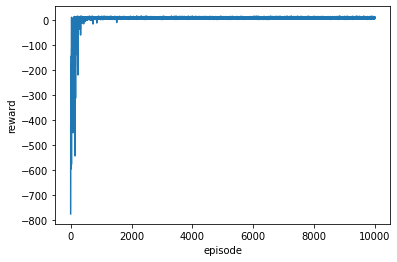

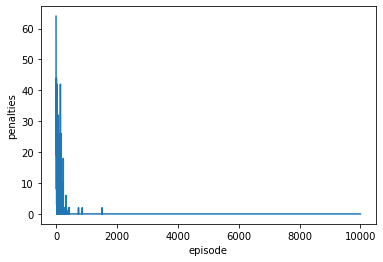

In [250]:
import random
import numpy as np
from pprint import pprint
from collections import defaultdict
from collections import deque
import matplotlib.pyplot as plt


#print(list(taxi.decode(state)), "taxi_row, taxi_col, pass_loc, dest_idx")
#pprint(taxi.P)


Q  = defaultdict(lambda: np.zeros(nr_action))


def epsilon_greedy_action(Q, state, epsilon):
    r = random.random()
    if r > epsilon:
        # greedy action
        return np.argmax(Q[state])
    else:
        random_action = random.randint(0, 5) 
        # just return the random action 
        return random_action


def trainig_uber_driver(Q, taxi, n_episodes, parameters):# epsilon=1, epsilon_decay=0.1, min_epsilon=0.1, alpha=0.1, gamma=1):
    # get values 
    epsilon = parameters["epsilon"]
    epsilon_decay = parameters["epsilon_decay"]
    min_epsilon = parameters["min_epsilon"]
    alpha = parameters["alpha"]
    gamma = parameters["gamma"]
    #print(n_episodes, epsilon, epsilon_decay, min_epsilon, alpha, gamma)
    nr_action=taxi.action_space.n

    all_rewards = []
    penalties_all_episodes = []
    for i_episode in range(1, n_episodes+1):
        state = taxi.reset()
        cum_reward = 0
        cum_penalty = 0
        while True:
            # agent selects an action
            action = epsilon_greedy_action(Q, state, epsilon)
            # agent performs the selected action
            next_state, reward, done, _ = taxi.step(action)
            
            if not done:
                Q[state][action] += alpha * (
                            reward + gamma * np.max(Q[next_state]) - Q[state][action])
            else:
                Q[state][action] += alpha * (reward - Q[state][action])
                epsilon = epsilon * epsilon_decay
                if min_epsilon is not None:
                    epsilon = max(epsilon, min_epsilon)
            # update the sampled reward
            cum_reward += reward
            if reward<-1:
                cum_penalty += 1
            #print (list(taxi.decode(next_state)), reward, done, cum_reward)
            # update the state (s <- s') to next time step
            state = next_state
            if done:
                # save final sampled reward
                all_rewards.append(cum_reward)
                penalties_all_episodes.append(cum_penalty)
                break
    #update parameters
    parameters["epsilon"] = epsilon
    parameters["epsilon_decay"] =epsilon_decay
    parameters["min_epsilon"] = min_epsilon
    parameters["alpha"] = alpha
    parameters["gamma"] = gamma
    return (all_rewards, penalties_all_episodes)

parameters = {
    "epsilon":1,#1,
    "epsilon_decay":0.0001,#0.2,#0.9,
    "min_epsilon":0.0,#0.1,
    "alpha":0.8,#0.4,0.01,
    "gamma":1#1
}

(all_rewards, penalties_all_episodes) = trainig_uber_driver(Q, taxi, 10000, parameters)
print("Avarage reward for the last 100 episoded", np.mean(all_rewards[-100:]))
print("Avarage penaltiesl for the last 100 episodes", np.mean(penalties_all_episodes[-100:]))

plt.plot(all_rewards)
plt.ylabel('reward')
plt.xlabel('episode')
plt.show()
plt.plot(penalties_all_episodes)
plt.ylabel('penalties')
plt.xlabel('episode')
plt.show()

#5. The algorithm should be able to perform pick-ups and dropoffs with zero penalties over 1000 episodes.
Okay so let's run 1000 more episodes to see the worst.

In [253]:
print("run another 1000 epsodes")


(all_rewards, penalties_all_episodes) = trainig_uber_driver(Q, taxi, 1000, parameters)

print("Quantile 5%% and 95%%",np.quantile(all_rewards, [ 0.5, 1]))

avg_100_ep_reward = []
for i in range(1000-100):
    avg_100_ep_reward.append( np.mean(all_rewards[i:i+100]))
avg_100_ep_reward = sorted(avg_100_ep_reward)
print("Worst 5%% of epsiode has an avg of %s which is higer than 7.2 "%(np.mean(all_rewards[:5])))
print("Best 95%% of epsiode has an avg of %s which is higer than 8.2 "%(np.mean(all_rewards[5:])))


run another 1000 epsodes
Quantile 5%% and 95%% [ 8. 15.]
Worst 5% of epsiode has an avg of 10.0 which is higer than 7.2 
Best 95% of epsiode has an avg of 8.857286432160803 which is higer than 8.2 


#6. Document your solution including all hyper parameters and how those hyperparameters were selected.

1. epsilon - chances to take the greedy action 
2. epsilon_decay - how much the epsilon decays after an episode.
3. min_epsilon - minumum epsilon
4. alpha - The accumulated returns is not always linear. Decrease the effect by setting this lower than one.
5. gamma- This is used to implement the discounted returns.



## Submission
- Submit your solution as a Jupyter notebook. 
- Ensure that all cells in the notebook have been executed and the output is showing
- Ensure that your solution consistently reaches the average cumulative reward defined in the rubric (link below)
- Post your solution on Github and share the link to your commit as a direct message in Slack

## Evaluation
The goal of the project is to get a certain average (cumulative) reward over 100 episodes. To pass the project, you must meet all the requirments in the project [rubric](https://github.com/KnowchowHQ/rl-in-action/blob/master/C1-RL-Intro/W3OH/P1-rubric.md)